# German Speed Limit Sign Recognition with Tensorflow and Keras

## How well are we really doing: Adding a more formal validation

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import warnings
warnings.filterwarnings('ignore')

## Installation of required libs Scikit Learn, TensorFlow, and Keras

In [3]:
!conda install --name root scikit-learn -y

Fetching package metadata .......
Solving package specifications: ..........

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-env-2.6.0            |                0          502 B

The following packages will be UPDATED:

    conda:     4.2.13-py35_0 conda-forge --> 4.3.13-py35_0

The following packages will be SUPERCEDED by a higher-priority channel:

    conda-env: 2.6.0-0       conda-forge --> 2.6.0-0      

Pruning fetched packages from the cache ...
Fetching packages ...
conda-env-2.6. 100% |################################| Time: 0:00:00 369.91 kB/s
Extracting packages ...
[      COMPLETE      ]|###################################################| 100%
Unlinking packages ...
[      COMPLETE      ]|###################################################| 100%
Linking packages ...
[      COMPLETE      ]|##

In [4]:
import sklearn
# should at least be 0.18
sklearn.__version__

'0.18.1'

In [5]:
!conda install --name root -c conda-forge tensorflow -y

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /home/nbcommon/anaconda3_410:

The following packages will be SUPERCEDED by a higher-priority channel:

    conda:     4.3.13-py35_0 --> 4.2.13-py35_0 conda-forge
    conda-env: 2.6.0-0       --> 2.6.0-0       conda-forge

conda-env-2.6. 100% |################################| Time: 0:00:00   1.21 MB/s


In [6]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
# should at least be 1.0
tf.__version__

'1.0.0'

In [7]:
!pip install keras

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [8]:
import keras as keras
# should at least be 1.2 and use TensorFlow backend
keras.__version__

Using TensorFlow backend.


'1.2.2'

## Download data

In [9]:
# https://notebooks.azure.com/faq#service_restrictions
# https://notebooks.azure.com/faq#upload_data
# https://notebooks.azure.com/n/xwZx1vmIroU/notebooks/Getting%20to%20your%20Data%20in%20Azure%20Notebooks.ipynb

In [10]:
!curl -O https://raw.githubusercontent.com/DJCordhose/speed-limit-signs/master/data/speed-limit-signs.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1810k  100 1810k    0     0  4083k      0 --:--:-- --:--:-- --:--:-- 4086k


In [11]:
# https://docs.python.org/3/library/zipfile.html
from zipfile import ZipFile
zip = ZipFile(r'speed-limit-signs.zip')
zip.extractall('.')

In [12]:
!ls -l speed-limit-signs

total 28
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 0
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 1
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 2
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 3
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 4
drwxr-xr-x 2 nbuser nbuser 4096 Feb 26 08:21 5
-rw-r--r-- 1 nbuser nbuser  380 Feb 26 11:24 README.md


## Analyse and Prepare Image Data

In [13]:
import os
import skimage.data

def load_data(data_dir):
    """Loads a data set and returns two lists:
    
    images: a list of Numpy arrays, each representing an image.
    labels: a list of numbers that represent the images labels.
    """
    # Get all subdirectories of data_dir. Each represents a label.
    directories = [d for d in os.listdir(data_dir) 
                   if os.path.isdir(os.path.join(data_dir, d))]
    # Loop through the label directories and collect the data in
    # two lists, labels and images.
    labels = []
    images = []
    for d in directories:
        label_dir = os.path.join(data_dir, d)
        file_names = [os.path.join(label_dir, f) 
                      for f in os.listdir(label_dir) if f.endswith(".ppm")]
        # For each label, load it's images and add them to the images list.
        # And add the label number (i.e. directory name) to the labels list.
        for f in file_names:
            images.append(skimage.data.imread(f))
            labels.append(int(d))
    return images, labels

In [14]:
# Load datasets.
ROOT_PATH = "./"
data_dir = os.path.join(ROOT_PATH, "speed-limit-signs")

images, labels = load_data(data_dir)

In [15]:
len(set(labels)), len(images)

(6, 379)

In [16]:
import matplotlib
import matplotlib.pyplot as plt

def display_images_and_labels(images, labels):
    """Display the first image of each label."""
    unique_labels = set(labels)
    plt.figure(figsize=(15, 15))
    i = 1
    for label in unique_labels:
        # Pick the first image for each label.
        image = images[labels.index(label)]
        plt.subplot(8, 8, i)  # A grid of 8 rows x 8 columns
        plt.axis('off')
        plt.title("Label {0} ({1})".format(label, labels.count(label)))
        i += 1
        _ = plt.imshow(image)
    plt.show()

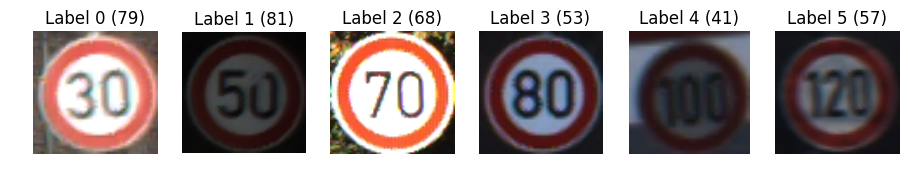

In [17]:
display_images_and_labels(images, labels)

In [18]:
for image in images[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (50, 50, 3), min: 11, max: 139
shape: (33, 33, 3), min: 6, max: 98
shape: (20, 22, 3), min: 24, max: 179
shape: (49, 49, 3), min: 7, max: 189
shape: (41, 41, 3), min: 8, max: 86


In [19]:
import skimage.transform

# Resize images
images64 = [skimage.transform.resize(image, (64, 64))
                for image in images]

In [20]:
for image in images64[:5]:
    print("shape: {0}, min: {1}, max: {2}".format(image.shape, image.min(), image.max()))

shape: (64, 64, 3), min: 0.045677274816176325, max: 0.5281192555147057
shape: (64, 64, 3), min: 0.040650371476715595, max: 0.37439084520526966
shape: (64, 64, 3), min: 0.09411764705882353, max: 0.6777516084558827
shape: (64, 64, 3), min: 0.03952612783394603, max: 0.7256433823529411
shape: (64, 64, 3), min: 0.03137254901960784, max: 0.32432909198835824


In [21]:
import numpy as np

y = np.array(labels)
X = np.array(images64)
y.shape, X.shape

((379,), (379, 64, 64, 3))

## Training a simple Keras model

In [22]:
from keras.utils.np_utils import to_categorical

num_categories = 6

y = to_categorical(y, num_categories)

### Starting with one fully connected layer and a softmax output

In [23]:
# https://keras.io/getting-started/functional-api-guide/
from keras.models import Model
from keras.layers import Dense, Flatten, Input

# this returns a tensor
inputs = Input(shape=(64, 64, 3))

x = Dense(256, activation='relu')(inputs)
x = Flatten()(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(input=inputs, output=predictions)

In [24]:
model.input_shape

(None, 64, 64, 3)

In [25]:
model.output_shape

(None, 6)

### Keras Models need to be compiled (to TensorFlow in our case) before usage

In [26]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Sklearn easily lets us split training (80%) from test data (%20) (and make it reproduceable)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((303, 64, 64, 3), (303, 6), (76, 64, 64, 3), (76, 6))

### Training with 15 epochs does not take very long (we also don't have a lot of data for training)

In [29]:
model.fit(X_train, y_train, nb_epoch=15, batch_size=32)

Epoch 1/15
303/303 [==============================] - 2s - loss: 11.5337 - acc: 0.1782     
Epoch 2/15
303/303 [==============================] - 2s - loss: 8.6750 - acc: 0.2508      

#### Results should be around 90% accuracy, not that bad

### Let us try a few random samples on the test data to see if we overfitted (informally for now)

In [30]:
import random

# Pick 10 random images for test data set
random.seed(3) # to make deterministic
sample_indexes = random.sample(range(len(X_test)), 10)
sample_images = [X_test[i] for i in sample_indexes]
sample_labels = [y_test[i] for i in sample_indexes]

In [31]:
sample_labels

[array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  0.,  1.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  1.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 0.,  0.,  1.,  0.,  0.,  0.]),
 array([ 0.,  1.,  0.,  0.,  0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  1.])]

In [32]:
# that is a tad hard to read, just choose the category

ground_truth = np.argmax(sample_labels, axis=1)
ground_truth

array([1, 5, 5, 3, 4, 4, 5, 2, 1, 5])

In [33]:
# now make the prediction for the sample inputs
X_sample = np.array(sample_images)
prediction = model.predict(X_sample)

In [34]:
# softmax predictions would be even harder to read, again just choose the hightst category

predicted_categories = np.argmax(prediction, axis=1)
predicted_categories

array([1, 5, 5, 0, 4, 4, 5, 1, 1, 4])

In [35]:
# Display the predictions and the ground truth visually.
def display_prediction (images, true_labels, predicted_labels):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(true_labels)):
        truth = true_labels[i]
        prediction = predicted_labels[i]
        plt.subplot(5, 2,1+i)
        plt.axis('off')
        color='green' if truth == prediction else 'red'
        plt.text(80, 10, "Truth:        {0}\nPrediction: {1}".format(truth, prediction), 
                 fontsize=12, color=color)
        plt.imshow(images[i])

## Visualizing where we were right (might be up to 7 out of 10)

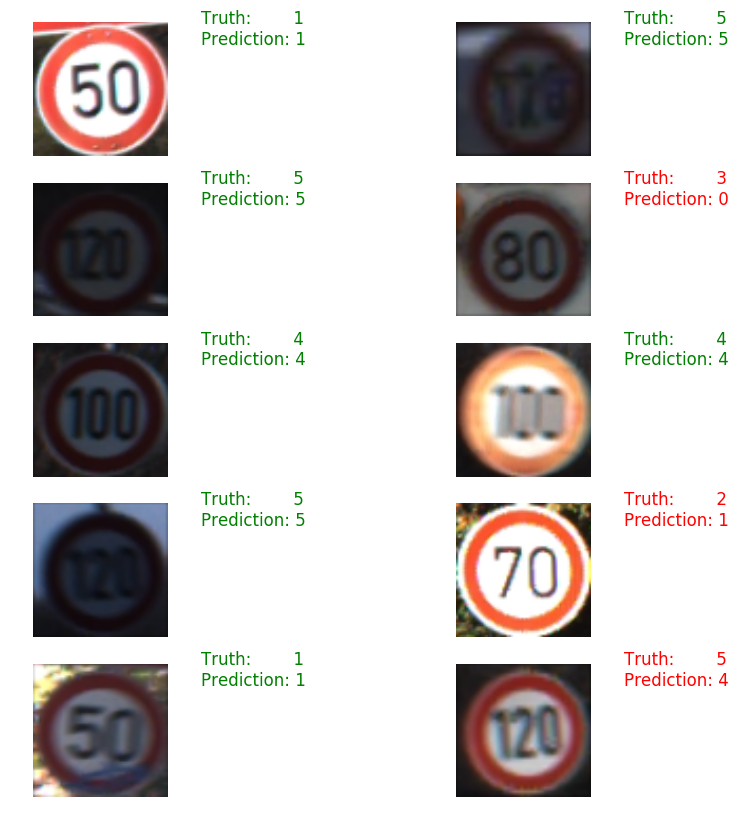

In [36]:
display_prediction(sample_images, ground_truth, predicted_categories)

## Let's see if there is anything special to the frequencencies

In [37]:
test_ground_truth = np.argmax(y_test, axis=1)
test_ground_truth

array([1, 5, 2, 1, 4, 2, 3, 0, 4, 1, 2, 3, 0, 0, 2, 0, 5, 1, 1, 4, 5, 4, 5,
       5, 0, 3, 0, 0, 0, 5, 1, 5, 1, 1, 2, 1, 0, 0, 1, 1, 5, 1, 0, 1, 2, 1,
       4, 3, 4, 3, 0, 1, 5, 3, 1, 1, 4, 1, 2, 2, 4, 2, 3, 0, 2, 3, 2, 2, 0,
       5, 1, 2, 5, 3, 3, 0])

In [38]:
np.bincount(test_ground_truth)

array([15, 19, 13, 10,  8, 11])

In [39]:
train_ground_truth = np.argmax(y_train, axis=1)
train_ground_truth

array([2, 3, 5, 3, 3, 0, 1, 3, 0, 4, 5, 5, 2, 2, 0, 4, 0, 2, 5, 4, 5, 5, 5,
       2, 0, 4, 3, 5, 3, 2, 3, 0, 0, 1, 5, 1, 4, 1, 1, 3, 4, 2, 1, 1, 4, 3,
       0, 1, 0, 1, 0, 4, 1, 4, 3, 1, 4, 1, 5, 5, 0, 0, 0, 2, 0, 0, 3, 5, 3,
       1, 1, 2, 0, 3, 3, 5, 2, 0, 4, 4, 5, 0, 1, 5, 1, 2, 0, 1, 1, 2, 2, 3,
       2, 5, 1, 0, 3, 3, 3, 5, 2, 0, 3, 4, 1, 2, 2, 1, 2, 5, 0, 0, 1, 2, 4,
       3, 1, 2, 0, 3, 4, 2, 5, 4, 1, 2, 0, 1, 1, 0, 1, 5, 4, 3, 1, 1, 0, 0,
       2, 4, 3, 3, 5, 4, 3, 2, 5, 1, 3, 5, 5, 2, 3, 4, 5, 4, 0, 0, 4, 2, 1,
       4, 2, 5, 4, 3, 2, 0, 0, 0, 1, 2, 2, 2, 2, 3, 0, 0, 1, 2, 4, 1, 1, 2,
       1, 1, 2, 0, 4, 2, 1, 0, 5, 2, 1, 2, 5, 4, 2, 5, 0, 5, 4, 1, 3, 1, 1,
       2, 5, 1, 0, 5, 3, 0, 3, 0, 2, 5, 4, 3, 3, 2, 3, 1, 5, 1, 1, 2, 2, 0,
       1, 1, 4, 3, 1, 0, 2, 5, 0, 5, 2, 1, 2, 5, 0, 3, 3, 1, 0, 3, 0, 2, 0,
       5, 0, 1, 0, 2, 1, 3, 0, 2, 3, 5, 5, 5, 3, 5, 5, 2, 0, 1, 5, 0, 5, 1,
       1, 0, 4, 0, 4, 1, 0, 1, 2, 1, 0, 1, 5, 4, 0, 0, 0, 0, 1, 3, 0, 2, 2,
       0, 2,

In [40]:
np.bincount(train_ground_truth)

array([64, 62, 55, 43, 33, 46])

In [41]:
test_prediction = np.argmax(model.predict(np.array(X_test)), axis=1)
test_prediction

array([1, 5, 2, 1, 4, 2, 3, 0, 4, 1, 1, 3, 0, 0, 2, 1, 5, 3, 1, 4, 5, 3, 5,
       5, 0, 1, 0, 0, 1, 4, 1, 5, 5, 1, 2, 1, 0, 0, 1, 1, 5, 1, 0, 1, 2, 1,
       3, 0, 4, 1, 0, 1, 4, 5, 1, 3, 4, 1, 2, 2, 4, 2, 5, 0, 2, 3, 2, 5, 0,
       5, 1, 1, 3, 1, 3, 0])

In [42]:
np.bincount(test_prediction)

array([14, 23, 10,  9,  8, 12])

In [43]:
train_prediction = np.argmax(model.predict(np.array(X_train)), axis=1)
train_prediction

array([2, 3, 5, 3, 3, 0, 1, 3, 0, 4, 5, 5, 2, 2, 0, 4, 0, 2, 5, 4, 5, 5, 5,
       2, 0, 4, 3, 5, 3, 2, 3, 0, 0, 1, 5, 1, 4, 1, 1, 3, 4, 5, 1, 1, 4, 3,
       0, 1, 1, 1, 0, 4, 1, 4, 3, 1, 4, 1, 5, 5, 0, 0, 0, 2, 0, 0, 3, 5, 3,
       1, 1, 2, 0, 3, 3, 5, 2, 0, 4, 4, 5, 0, 1, 5, 1, 2, 0, 1, 1, 2, 2, 3,
       2, 5, 1, 0, 3, 3, 3, 5, 2, 0, 3, 4, 1, 2, 2, 1, 3, 5, 0, 0, 1, 2, 4,
       3, 1, 2, 0, 3, 4, 5, 5, 4, 1, 2, 0, 1, 1, 0, 1, 5, 4, 3, 1, 1, 0, 0,
       2, 4, 3, 3, 5, 4, 3, 2, 5, 1, 3, 5, 5, 2, 3, 4, 5, 4, 0, 0, 4, 2, 1,
       4, 2, 5, 4, 3, 2, 0, 0, 0, 1, 2, 2, 2, 2, 3, 0, 0, 1, 2, 4, 1, 1, 2,
       1, 1, 2, 0, 4, 2, 1, 0, 5, 2, 1, 2, 5, 4, 2, 5, 0, 5, 4, 1, 3, 1, 1,
       2, 5, 1, 4, 5, 3, 0, 3, 3, 2, 5, 4, 3, 3, 2, 3, 1, 5, 1, 1, 2, 2, 0,
       1, 1, 4, 3, 1, 0, 2, 5, 0, 5, 2, 1, 2, 5, 0, 3, 3, 1, 0, 3, 0, 2, 0,
       5, 0, 1, 0, 2, 1, 3, 0, 2, 3, 5, 5, 5, 3, 5, 5, 2, 0, 1, 5, 0, 5, 1,
       1, 0, 4, 0, 4, 1, 0, 1, 2, 1, 0, 1, 5, 4, 0, 0, 0, 0, 1, 3, 0, 2, 2,
       0, 2,

In [44]:
np.bincount(train_prediction)

array([61, 63, 52, 45, 34, 48])

## Finally just the plain scores for train (>90%) and test (~70%) data

In [45]:
# https://keras.io/models/sequential/#evaluate
train_loss, train_accuracy = model.evaluate(X_train, y_train, batch_size=32)
train_loss, train_accuracy

303/303 [==============================] - 0s     


(0.25010817751239234, 0.98019801980198018)

In [46]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, batch_size=32)
test_loss, test_accuracy

64/76 [========================>.....] - ETA: 0s

(0.80884138533943573, 0.75000000313708659)